In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
# import lime.lime_tabular_mod as lime_tab
import lime.lime_tabular_multiclassifier as lime_tab

import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
111,6.4,2.7,5.3,1.9,Iris-virginica
36,5.5,3.5,1.3,0.2,Iris-setosa
123,6.3,2.7,4.9,1.8,Iris-virginica
6,4.6,3.4,1.4,0.3,Iris-setosa
101,5.8,2.7,5.1,1.9,Iris-virginica
...,...,...,...,...,...
68,6.2,2.2,4.5,1.5,Iris-versicolor
20,5.4,3.4,1.7,0.2,Iris-setosa
113,5.7,2.5,5.0,2.0,Iris-virginica
73,6.1,2.8,4.7,1.2,Iris-versicolor


### Prepare dataset 

In [3]:
labels_column_name = "label"
# jackknife_idx = random.choice(iris_dataset.index.to_numpy())
jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-virginica']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LTEMultiDecisionTree(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    discretize_continuous=False,
    with_kfold = 5,
    use_inversed_data_for_training=True
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 1.0}


Explain the instance

array([0., 0., 1.])

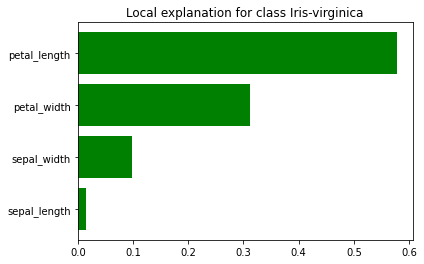

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
118,7.7,2.6,6.9,2.3,Iris-virginica


In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))


[0, 0, 1]
[0, 0, 1]
[0.0, 0.0, 1.0]


In [10]:
print("MSE on training set:", np.array(explanation.get_losses_for_surrogate_model()))
print("MSE on cv-test  set:", np.mean(explanation.get_losses_for_cv_model(), axis=1))
print("std on cv-test  set:", np.std(explanation.get_losses_for_cv_model(), axis=1))

MSE on training set: [0.0408 0.2098 0.029 ]
MSE on cv-test  set: [0.052  0.157  0.0428]
std on cv-test  set: [0.00787401 0.032839   0.00733212]


In [11]:
explanation.get_fidelity_loss_on_kfold()

array([0.06422222, 0.05672222, 0.06438889, 0.06122222, 0.07444444])

In [12]:
explanation.get_fidelity_loss_on_explanation()


0.0

In [13]:
explanation.get_fidelity_loss_on_generated_data()


0.06348888888888894

In [14]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(2, 0.5775161756689984),
 (3, 0.3109739677732755),
 (1, 0.0974203652289451),
 (0, 0.01408949132878105)]

In [15]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, 0.5877642770345117),
 (3, 0.26206188332693303),
 (1, 0.1086382463762626),
 (0, 0.04153559326229263)]

In [16]:
explanation.as_map()

{0: [(3, 0.6746199213633652),
  (2, 0.24122066558706112),
  (0, 0.08415941304957364),
  (1, 0.0)],
 1: [(2, 0.5877642770345117),
  (3, 0.26206188332693303),
  (1, 0.1086382463762626),
  (0, 0.04153559326229263)],
 2: [(2, 0.5775161756689984),
  (3, 0.3109739677732755),
  (1, 0.0974203652289451),
  (0, 0.01408949132878105)]}

In [17]:
explainer.discretizer.names

AttributeError: 'NoneType' object has no attribute 'names'

In [ ]:
explainer.discretizer.maxs

Update some attributes to see if probabilities would change

In [ ]:
top_features = explanation.as_map()[predicted_label_id]
top_features